## Importing the necessary packages

In [ ]:
# !pip install -q tensorflow==2.18.0
# !pip install -q tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html

# # # 2. FIX JAX (Re-upgrade ml_dtypes so JAX doesn't kill the kernel)
# !pip install -q "ml_dtypes>=0.5.0"

# print("NOW RESTART THE SESSION MANUALLY!")

In [1]:
import tensorflow as tf

print(f"TensorFlow Version: {tf.__version__}")


# tpu='local' is the secret key for Kaggle VMs
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

print(f"SUCCESS! TPU Initialized.")
print(f"Replicas: {strategy.num_replicas_in_sync}")

E0000 00:00:1769762915.345443  123093 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
/usr/local/lib/python3.12/site-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "
/usr/local/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.18.0
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1769762925.080283  123093 service.cc:148] XLA service 0x570f29a4d160 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769762925.080327  123093 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1769762925.080330  123093 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1769762925.080332  123093 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1769762925.080333  123093 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1769762925.080335  123093 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1769762925.080336  123093 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1769762925.080338  123093 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1769762925.080339  123093 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [2]:
import cv2
import numpy as np
import glob
from tqdm import tqdm
import sys
import os
# import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix

## Loading and preprocessing images from the DeepGlobe dataset

In [ ]:
%%capture
# Download dataset if not already present.
!curl -L -o deepglobe-land-cover-classification-dataset.zip https://www.kaggle.com/api/v1/datasets/download/balraj98/deepglobe-land-cover-classification-dataset
!unzip deepglobe-land-cover-classification-dataset.zip -d deepglobe-land-cover-classification-dataset

In [3]:
path = os.path.join("deepglobe-land-cover-classification-dataset")

IMG_SHAPE = (2448, 2448, 3) # Original image shape
INPUT_SHAPE = (1224, 1224, 3) # Model image shape
OUT_SHAPE = (1224, 1224, 1) # Output mask shape

In [4]:
def preprocess_img(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if INPUT_SHAPE != IMG_SHAPE:
        #cv2.INTER_LANCZOS4, cv2.INTER_LINEAR, and cv2.INTER_CUBIC can improve performance.
        image = cv2.resize(image, INPUT_SHAPE[:-1], interpolation = cv2.INTER_AREA)
    return image.astype(np.uint8)

def preprocess_mask(mask_path):
    # Transforming masks from 3 channel to a singular class channel with values from 0 to 6.
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_shape = OUT_SHAPE[:-1] + (3, )
    if IMG_SHAPE != mask_shape:
        mask = cv2.resize(mask, OUT_SHAPE[:-1], interpolation = cv2.INTER_NEAREST)

    mask = np.array(np.round(mask / 255.0), dtype = np.uint8)
    assert np.all(np.logical_or(mask == 1.0, mask == 0.0))

    mask_1c = 4 * mask[:,:,0] + 2 * mask[:,:,1] + mask[:,:,2]
    assert np.sum(mask_1c == 4) == 0
    # Since class index 4 (pure red) is unused, 7 is replaced by 4.
    mask_1c = mask_1c * (mask_1c != 7) + 4 * (mask_1c == 7)
    return mask_1c.astype(np.uint8)


def get_dataset(mask_dirs):
    # Each mask file is matched to its corresponding satellite image.
    sat_dirs = [d.replace("_mask.png", "_sat.jpg") for d in mask_dirs]

    X = np.stack([preprocess_img(file) for file in sat_dirs], axis = 0)
    y = np.stack([preprocess_mask(file) for file in mask_dirs], axis = 0)

    return X, y

In [5]:
# Loading the labeled data.
train_path = os.path.join(path, "train")
mask_dirs = glob.glob(os.path.join(train_path,"*_mask.png"))

# Shuffle the data.
random.seed(42)
random.shuffle(mask_dirs)

n = len(mask_dirs)
train_split = 0.8
n_train = int(n * train_split)
n_val = n - n_train

X_train, y_train = get_dataset(mask_dirs[:n_train])
print(f"Loaded {n_train} training images.")

#X_val, y_val = get_dataset(os.path.join(path, "valid"))
#X_test, y_test = get_dataset(os.path.join(path, "test"))

Loaded 642 training images.


In [6]:
X_val, y_val = get_dataset(mask_dirs[n_train:n])
print(f"Loaded {n_val} validation images.")

Loaded 161 validation images.


In [7]:
def flip_image(img, horizontal = False, vertical = False):
    assert len(img.shape) >= 2
    if len(img.shape) == 2:
        img = tf.expand_dims(img, -1)

    if vertical:
        img = tf.image.flip_up_down(img)
    if horizontal:
        img = tf.image.flip_left_right(img)

    return img

def random_flip(X, y, p = 0.5):
    h = tf.keras.random.uniform((1,), seed = 42) < p
    v = tf.keras.random.uniform((1,), seed = 42) < p

    return flip_image(X, h, v), flip_image(y, h, v)

In [8]:
def augment_image(X, y, t = 0.05):
    # Translation.
    dy = tf.random.uniform([], -t, t) * INPUT_SHAPE[0]
    dx = tf.random.uniform([], -t, t) * INPUT_SHAPE[1]

    translation_matrix = tf.convert_to_tensor([[1, 0, -dx],
                                            [0, 1, -dy],
                                            [0, 0, 1]], dtype=tf.float32)


    # First 6 entries of 3x3 matrix are the affine parameters, 7th and 8th should just be 0.
    transform_matrix = tf.cast(translation_matrix, tf.float32)
    transform_params = tf.reshape(transform_matrix, (1, 9))[:, :8]

    X = tf.keras.ops.image.affine_transform(
    X,
    transform_params,
    interpolation='bilinear',
    fill_mode='nearest',
    data_format='channels_last'
    )

    y  = tf.keras.ops.image.affine_transform(
    tf.expand_dims(y, axis = -1),
    transform_params,
    interpolation='nearest',
    fill_mode='nearest',
    data_format='channels_last'
    )

    return X, tf.squeeze(y, axis = -1)

In [9]:
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

def create_dataset(X, y, training = False):
    if not type(X) == tf.Tensor:
        X = tf.convert_to_tensor(X, dtype = tf.uint8)
    if not type(y) == tf.Tensor:
        y = tf.convert_to_tensor(y, dtype = tf.uint8)

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        dataset = dataset.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
        # dataset = dataset.map(augment_image)
    
    dataset = dataset.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)\
    .batch(BATCH_SIZE, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
    return dataset

train_set = create_dataset(X_train, y_train, training = True)
val_set = create_dataset(X_val, y_val, training = False)

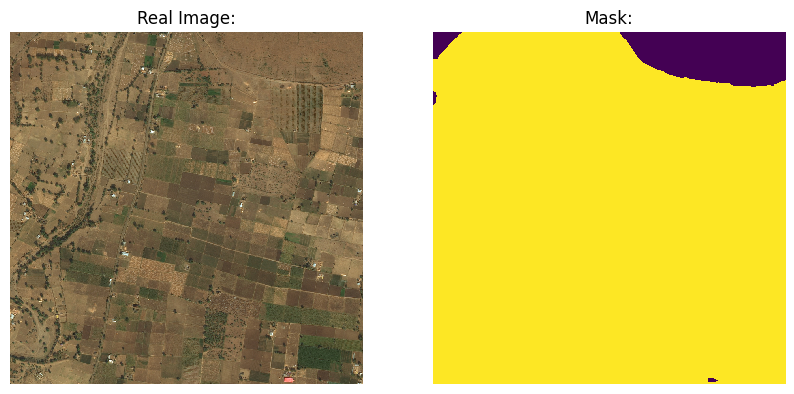

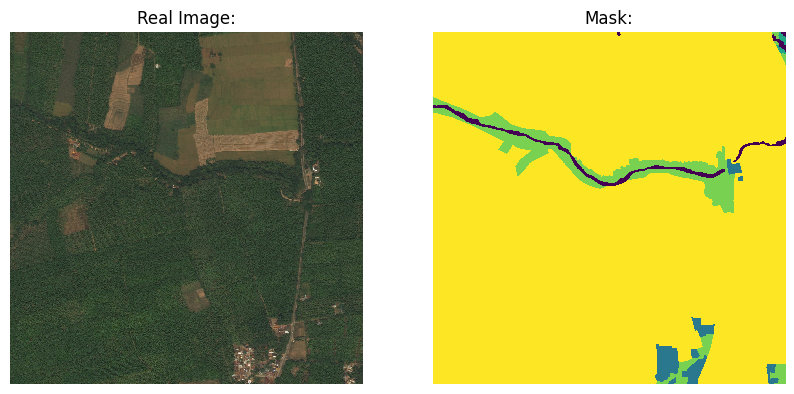

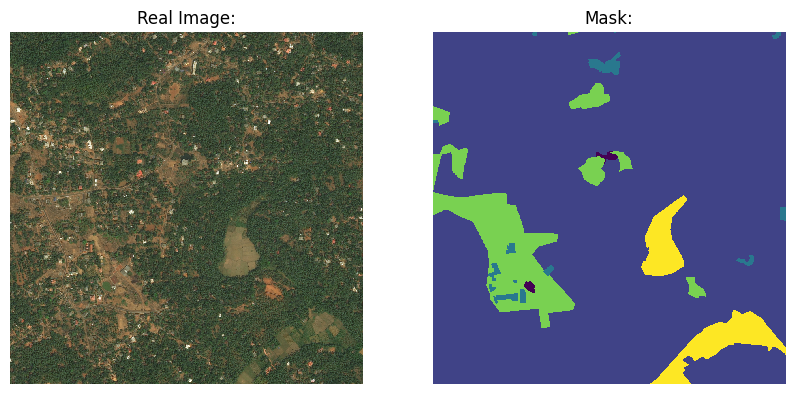

In [10]:
for i in range(3):
    x, y = X_train[i], y_train[i]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot real image
    axes[0].imshow(x, interpolation = 'none')
    axes[0].axis('off')
    axes[0].set_title("Real Image:")

    # Plot predicted mask
    axes[1].imshow(y, interpolation = 'none')
    axes[1].axis('off')
    axes[1].set_title("Mask:")
    plt.show()

## Model definition

In [11]:
# 2 consecutive padded convolutions with ReLU activations as outlined in the U-Net paper.
# Is the basis for both in the Encoder and the Decoder.
PADDING = "same"
POOLING = 2

class ConvBlock(tf.keras.Layer):
    def __init__(self, n_filters, filter_size):
        super().__init__()
        self.n_filters = n_filters
        self.cn1 = tfl.Conv2D(n_filters, filter_size,
                            padding = PADDING, use_bias = True)
        self.relu1 = tfl.ReLU()
        self.gn1 = tfl.GroupNormalization(groups=16)
        self.cn2 = tfl.Conv2D(n_filters, filter_size,
                            padding = PADDING, use_bias = True)
        self.relu2 = tfl.ReLU()
        self.gn2 = tfl.GroupNormalization(groups=16)

    def build(self, input_shape):
        B, H, L, C = input_shape
        self.cn1.build((B, H, L, C))
        self.gn1.build((B, H, L, self.n_filters))
        self.relu1.build((B, H, L, self.n_filters))

        self.cn2.build((B, H, L, self.n_filters))
        self.gn2.build((B, H, L, self.n_filters))
        self.relu2.build((B, H, L, self.n_filters))
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        B, H, L, _ = input_shape
        return (B, H, L, self.n_filters)

    def call(self, x, training = False):
        x = self.gn1(self.cn1(x))
        # x = self.cn1(x)
        x = self.relu1(x)

        x = self.gn2(self.cn2(x))
        # x = self.cn2(x)
        x = self.relu2(x)
        return x

In [12]:
class UNetConv(ConvBlock):
    def __init__(self, n_filters, filter_size):
        super().__init__(n_filters, filter_size)
        # Pooling layer to reduce image resolution.
        self.pool = tfl.MaxPooling2D(POOLING)

    def call(self, x, training = False):
        x = super().call(x, training = training)
        return x, self.pool(x)

    def build(self, input_shape):
        B, H, L, C = input_shape
        self.pool.build((B, H, L, self.n_filters))
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        B, H, L, C = input_shape
        return (B, H // 2, L // 2, self.n_filters)


class UNetTConv(ConvBlock):
    def __init__(self, filters, filter_size, tfilters, tfilter_size, dropout = 0.0):
        super().__init__(filters, filter_size)
        # ConvTranspose to restore image resolution, convolution stride is the pooling stride.
        self.dcn = tfl.Conv2DTranspose(tfilters, tfilter_size, POOLING, padding = "same")
        self.dropout = tfl.Dropout(dropout)
        self.tfilters = tfilters

    def build(self, input_shape):
        B, H, L, C = input_shape
        self.dcn.build((B, H, L, C))
        self.dropout.build((B, H * 2, L * 2, C // 2))
        super().build((B, H * 2, L * 2, C))

    def compute_output_shape(self, input_shape):
        B, H, L, C = input_shape
        return (B, H * 2, L * 2, self.n_filters)

    def call(self, x, skip, training = False):
        x = self.dcn(x)
        x = tf.concat([x, skip], axis = -1)
        x = self.dropout(x, training = training)
        return super().call(x, training = training)

In [101]:
n_blocks = 3 # Number of encoder and decoder blocks.
log_conv_filters = 6 # Number of filters in the first convolutional layer is 2^log_conv_filters.
# Increased by a factor of 2 for each subsequent layer. Inverse order for the decoder.
n_classes = 7 # Number of possible classes for each output pixel.
filter_size = 3 # Convolution filter size: 3*3
tfilter_size = 2 # Transposed convolution filter size: 2*2.
dropout = 0.15 #0

bright_factor = 0.0
contrast_factor = 0.0

In [102]:
class UNET(tf.keras.Model):

    def __init__(self, blocks):
        super().__init__()
        self.scale = tfl.Rescaling(1.0 / 255.0)
        self.augment = tf.keras.Sequential([tfl.RandomBrightness(bright_factor, [0.0, 1.0]),
                                            tfl.RandomContrast(contrast_factor)])

        self.filters = [2**(log_conv_filters+i) for i in range(blocks)]
        # Encoder
        self.convs = [UNetConv(filters, filter_size) for filters in self.filters]
        # Conv block between downsampling and upsampling.
        self.bottleneck = ConvBlock(2 * self.filters[-1], filter_size)
        # Decoder
        self.tconvs = [UNetTConv(filters, filter_size, filters, tfilter_size, dropout) for filters in self.filters[::-1]]
        # Convolution across the channels to get 1 probability per class.
        self.conv1x1 =  tfl.Conv2D(n_classes, 1) 
        # self.softmax = tfl.Softmax(axis = -1)

    def build(self, input_shape):
        B, H, L, C = input_shape
        self.scale.build(input_shape)
        self.augment.build(input_shape)

        for conv, filters in zip(self.convs, [C, *self.filters[:-1]]):
            conv.build((B, H, L, filters))
            H, L = H // 2, L // 2

        filters = self.filters[-1]
        self.bottleneck.build((B, H, L, self.filters[-1]))
        filters = filters * 2

        for tconv in self.tconvs:
            tconv.build((B, H, L, filters))
            filters = filters // 2
            H, L = H * 2, L * 2

        self.conv1x1.build((B, H, L, filters))
        super().build(input_shape)

    def call(self, x, training = False):
        
        x = self.scale(x)
        x = self.augment(x, training = training)
    
        xs = []
        for conv in self.convs:
            # storing the unpooled feature maps for skip connections.
            skip, x = conv(x, training = training)
            xs.append(skip)

        x = self.bottleneck(x, training = training)

        for tconv, skip in zip(self.tconvs, xs[::-1]):
            x = tconv(x, skip, training = training)

        x = self.conv1x1(x)

        return x

## Training

In [103]:
epsilon = 1e-9 # To avoid log(0).

freqs = np.zeros((n_classes,))
for c in range(n_classes):
    freqs[c] = np.mean(y_train == c)

unknown_class = 0
beta = 0.1
class_weights = (1 - beta) / (1 - beta**freqs + 1e-6)
class_weights[0] /= 100
print(class_weights)
class_weights = tf.constant(class_weights, dtype = tf.float32)

class WeightedCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):

        y_true = tf.reshape(tf.cast(y_true, tf.uint8),(-1, ))
        y_true = tf.one_hot(y_true, n_classes) * class_weights

        # y_pred = (batch_size, n_classes)
        y_pred = tf.reshape(y_pred, (-1, n_classes))
        y_pred = y_pred - tf.reduce_max(y_pred, axis = -1, keepdims = True)
        log_prob = - tf.math.log(tf.nn.softmax(y_pred, axis = -1) + epsilon)
    
        return tf.reduce_sum(y_true * log_prob, axis = -1)

[ 6.41939956 11.37721311  3.76553455  4.23216196  4.83323346  5.07994828
  1.23463029]


In [104]:
@tf.function
def DiceLoss(y_true, y_pred):
    # Class weights?
    y_true = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes)
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    y_pred = tf.nn.softmax(y_pred, axis = -1)

    return 1 - 2 * tf.reduce_sum(y_pred * y_true) / tf.reduce_sum(y_true  + y_pred)

In [105]:
# F1 per class is used as the evaluation metric.
f1_score = tf.keras.metrics.F1Score(average = "weighted")
@tf.function
def F1(y_true, y_pred):
    # Includes empty class.
    f1_score.reset_state()
    y_true_flat = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes, dtype=tf.int16)
    y_pred_flat = tf.one_hot(tf.reshape(tf.argmax(y_pred, axis = -1), (-1,)), n_classes, dtype=tf.int16)
    return f1_score(y_true_flat, y_pred_flat)

In [106]:
def flat_shape(shape):
    acc = 1.0
    for x in shape:
        acc *= x
    return acc

In [107]:
@tf.function
def IoU(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.uint8)
    y_pred = tf.cast(tf.reshape(tf.argmax(y_pred, axis = -1), (-1,)), tf.uint8)
    intersection = tf.reduce_sum(tf.cast(y_pred == y_true, tf.int32))
    union = y_pred.shape[0]
    return intersection / union

In [108]:
inputs = tf.keras.Input(INPUT_SHAPE)
lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=450,
    decay_rate=0.92,
    staircase=True)

In [109]:
#DiceLoss #tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
with strategy.scope():
    loss_fn = WeightedCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.AdamW(lr_schedule)
    model = UNET(n_blocks)
    model(inputs)
    model.compile(optimizer, loss_fn, metrics = [IoU, F1])
    model.summary()

Model: "unet_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 1224, 1224, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 1224, 1224, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_12 (UNetConv)        │ (None, 612, 612, 64)   │        38,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_13 (UNetConv)        │ (None, 306, 306, 128)  │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_14 (UNetConv)        │ (None, 153, 153, 256)  │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_4 (ConvBlock)        │ (None, 153, 153, 512)  │     3,542,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_12 (UNetTConv)     │ (None, 306, 306, 256)  │     2,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_13 (UNetTConv)     │ (None, 612, 612, 128)  │       574,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_14 (UNetTConv)     │ (None, 1224, 1224, 64) │       143,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 1224, 1224, 7)  │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,703,367 (29.39 MB)

 Trainable params: 7,703,367 (29.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = {}
EPOCHS = 200

# tqdm logs to stderr by default.
# stderr = sys.stderr
# sys.stderr = sys.stdout

In [113]:
history = model.fit(train_set,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_set,
    shuffle=False,
    callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True))

Epoch 1/200


I0000 00:00:1769776496.648261  123093 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17672836927790277864
I0000 00:00:1769776497.516239  124197 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1430206293704538491), session_name()
I0000 00:00:1769776530.486994  124197 tpu_compile_op_common.cc:245] Compilation of 1430206293704538491 with session name  took 32.970714077s and succeeded
I0000 00:00:1769776530.534345  124197 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1430206293704538491), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17672836927790277864", property.function_library_fingerprint = 10831932128084198339, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - F1: 0.4111 - IoU: 0.3431 - loss: 5.7805

I0000 00:00:1769776567.278014  123093 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:3067978847261641711
I0000 00:00:1769776567.442953  124205 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13898862541253038250), session_name()
I0000 00:00:1769776585.651035  124205 tpu_compile_op_common.cc:245] Compilation of 13898862541253038250 with session name  took 18.208036437s and succeeded
I0000 00:00:1769776585.662893  124205 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13898862541253038250), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_3067978847261641711", property.function_library_fingerprint = 9842460085417038124, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 744ms/step - F1: 0.4766 - IoU: 0.4056 - loss: 4.9576 - val_F1: 0.3755 - val_IoU: 0.2810 - val_loss: 4.3028
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 497ms/step - F1: 0.5434 - IoU: 0.4753 - loss: 4.4891 - val_F1: 0.5422 - val_IoU: 0.4602 - val_loss: 4.0165
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 505ms/step - F1: 0.6112 - IoU: 0.5666 - loss: 4.0690 - val_F1: 0.6223 - val_IoU: 0.5719 - val_loss: 3.5843
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 506ms/step - F1: 0.6026 - IoU: 0.5669 - loss: 3.8052 - val_F1: 0.5175 - val_IoU: 0.4700 - val_loss: 3.4939
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 514ms/step - F1: 0.6507 - IoU: 0.6283 - loss: 3.4569 - val_F1: 0.6122 - val_IoU: 0.5532 - val_loss: 3.1277
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - F1: 0.6713 - IoU: 0.6518 - loss: 3.1819 - val_F1: 0.6888 - val_IoU: 0.6449 - val_loss: 2.9428
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 505ms/step - F1: 0.6868 - IoU: 0.6685 - loss: 2.9820 - val_F1: 0.7407

In [ ]:
# We reconfigure stderr to default
# sys.stderr = stderr
history = history.history

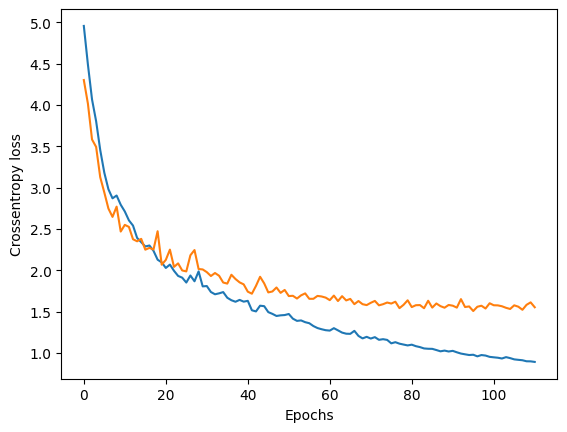

In [116]:
plt.plot(history["loss"], label = "Training loss")
plt.plot(history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

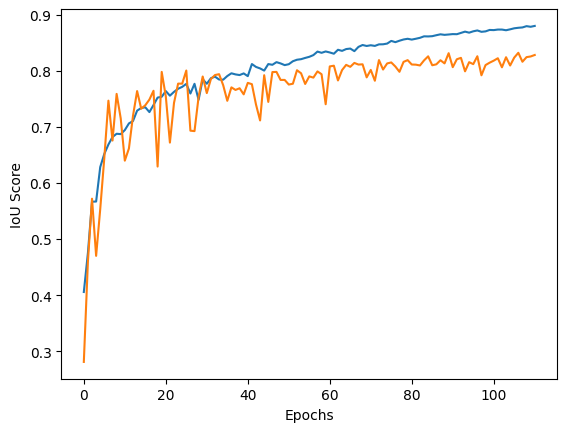

In [117]:
plt.plot(history["IoU"], label = "Training IoU")
plt.plot(history["val_IoU"], label = "Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.show()

## Evaluation

In [118]:
def mIoU(dataset):
    cm = np.zeros((n_classes, n_classes)) # confusion_matrix
    
    for X_batch, y_batch in dataset:
        y_pred = model(X_batch, training = False)
        y_pred_flat = tf.reshape(tf.argmax(y_pred, axis = -1), (-1,)).numpy()
        y_true_flat = tf.reshape(y_batch, (-1, )).numpy()
        cm += confusion_matrix(y_true_flat, y_pred_flat, labels = np.arange(n_classes))

    ious = []
    for c in range(n_classes):
        ious.append(float(cm[c, c] / (np.sum(cm[c]) + np.sum(cm[c, :]) - cm[c, c])))
    print(ious)
    return np.mean(ious)

In [125]:
print(f"The validation mean IoU is {mIoU(val_set):0.4f}.")
# print(f"The training mean IoU is {mIoU(train_set):0.4f}.")

[0.4976436840487655, 0.6313811021593965, 0.7346673362976348, 0.7835346535290029, 0.6247123331871416, 0.46406481103198416, 0.694362461175606]
The validation mean IoU is 0.6329.


In [120]:
def predict_mask(X_target):
    if len(X_target.shape) == 3:
        # Add batch dimension
        X_target = tf.reshape(X_target, (1,) + X_target.shape)

    y_pred = tf.argmax(model(X_target), axis = -1)[0]
    
    return y_pred

In [121]:
def to_img(y):
    """Convert class mask back to image for visualization."""
    out = np.zeros(y.shape[:2] + (3,))

    out[:, :, 0] = (y // 4)
    out[:, :, 1] = ((y % 4) // 2)
    out[:, :, 2] = (y % 2)

    return out

In [122]:
def confusion_matrix_show(cm):
    class_labels = list(range(n_classes))
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [123]:
def Visualize_output(X_target, y_target):
    logit_pred = model(tf.expand_dims(X_target, 0))
    y_pred = tf.argmax(logit_pred, axis = -1)[0]
    img_pred = to_img(y_pred)
    img_real = to_img(y_target)

    y_target_flat = tf.reshape(y_target,-1)
    y_pred_flat = tf.reshape(y_pred, -1)

    cm = confusion_matrix(y_target_flat, y_pred_flat, labels = np.arange(n_classes))
    confusion_matrix_show(cm)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Plot real image
    axes[0].imshow(X_target, interpolation = 'none')
    axes[0].axis('off')
    axes[0].set_title("Real Image:")

    # Plot predicted mask
    axes[1].imshow(img_pred, interpolation = 'none')
    axes[1].axis('off')
    axes[1].set_title(f"Predicted Mask: IoU: ({IoU(y_target, logit_pred):0.4f})")

    # Plot target mask
    axes[2].imshow(img_real, interpolation = 'none')
    axes[2].axis('off')
    axes[2].set_title("Real Mask:")

    # Display the images
    plt.tight_layout()
    plt.show()

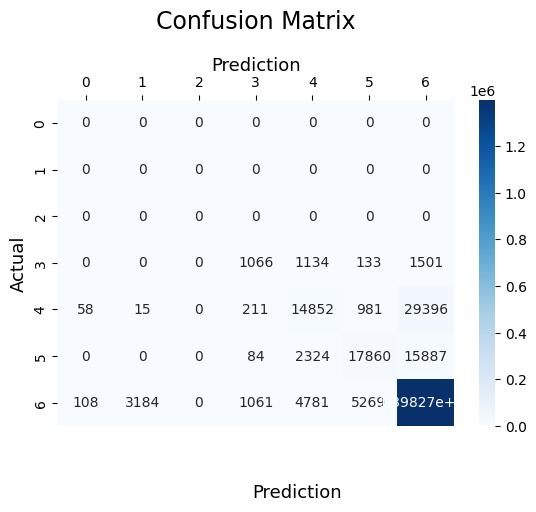

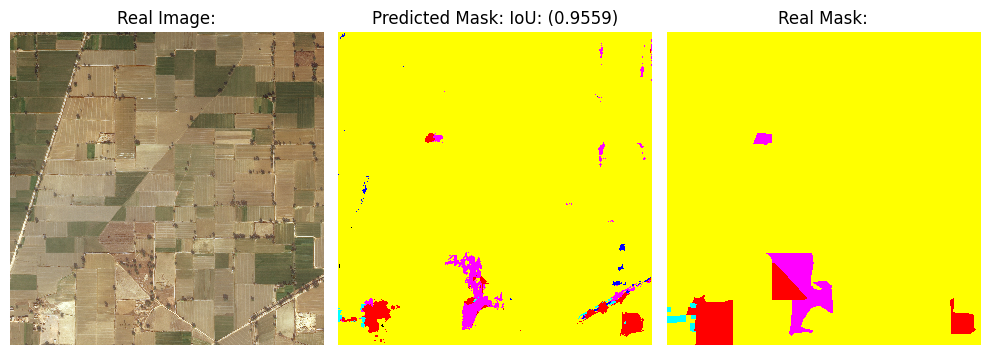

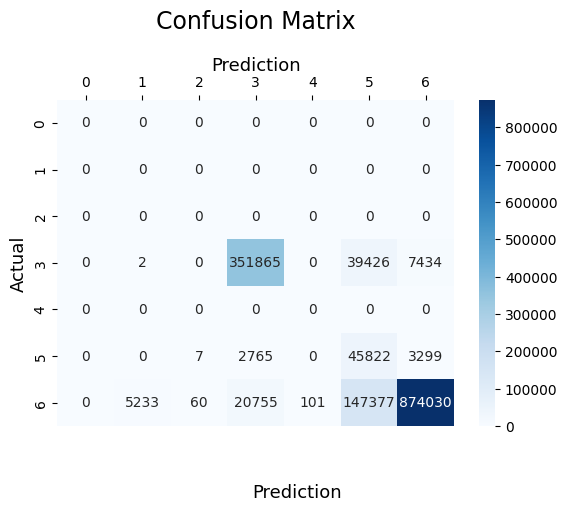

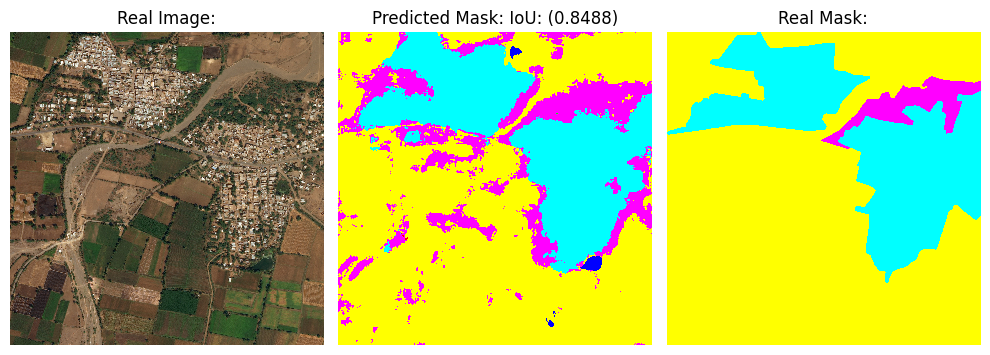

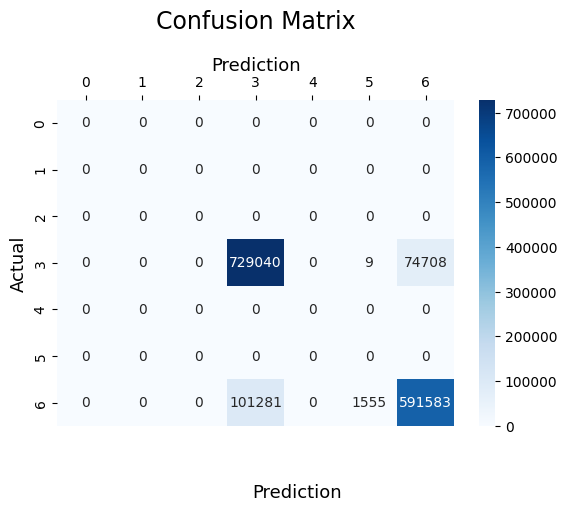

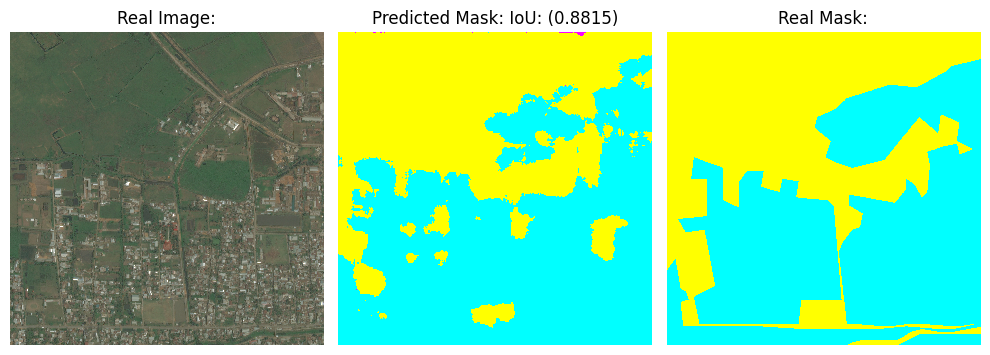

In [124]:
random_indices = np.random.randint(0, n_val, 3)
for i in random_indices:
    Visualize_output(X_val[i], y_val[i])